<a href="https://www.kaggle.com/code/turhangksu/metal-surface-vgg16?scriptVersionId=148779514" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/Thumbs.db
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_113.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_12.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_114.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_117.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_112.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_111.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_11.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_110.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/

In [2]:
# Define data directory paths
train_data_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
test_data_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
valid_data_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'

In [3]:
# Define class names
class_names = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

# DATA AUGMENTATION

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True 
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Data Generators
batch_size = 32
input_shape = (200, 200, 3)
num_classes = len(class_names)


train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

valid_generator = datagen.flow_from_directory(
    valid_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [6]:
for image_batch, labels_batch in train_generator:
    print("Batch Shape (Images):", image_batch.shape)
    print("Batch Shape (Labels):", labels_batch.shape)
    break

Batch Shape (Images): (32, 200, 200, 3)
Batch Shape (Labels): (32, 6)


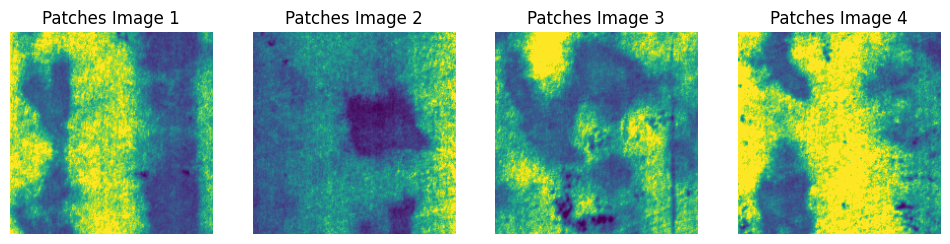

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

class_name = 'Patches'
class_dir = os.path.join(train_data_dir, class_name)
sample_images = random.sample(os.listdir(class_dir), 4)  

plt.figure(figsize=(12, 6))
for i, image_file in enumerate(sample_images):
    plt.subplot(1, 4, i + 1)
    image = mpimg.imread(os.path.join(class_dir, image_file))
    plt.imshow(image)
    plt.title(f'{class_name} Image {i + 1}')
    plt.axis('off')

plt.show()

# VGG16

In [8]:
# Create a custom classification model with AdamW optimizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa # for adamW

# Create a VGG16 model with pre-trained weights (include_top=False to exclude the top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Create your custom classification head
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2)) 
model.add(layers.Dense(num_classes, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


58889256/58889256 [==============================] - 0s 0us/step


In [9]:
# Define the AdamW optimizer
optimizer = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4)

In [10]:
# Compile the model with the AdamW optimizer
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)


In [11]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 24,155,462
Trainable params: 24,155,462
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
52/52 [==============================] - 52s 672ms/step - loss: 0.8769 - accuracy: 0.6950 - val_loss: 0.1063 - val_accuracy: 0.9583
Epoch 2/30
52/52 [==============================] - 22s 411ms/step - loss: 0.1212 - accuracy: 0.9565 - val_loss: 0.0162 - val_accuracy: 1.0000
Epoch 3/30
52/52 [==============================] - 21s 396ms/step - loss: 0.0388 - accuracy: 0.9879 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 4/30
52/52 [==============================] - 21s 400ms/step - loss: 0.0431 - accuracy: 0.9849 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 5/30
52/52 [==============================] - 21s 399ms/step - loss: 0.0206 - accuracy: 0.9928 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/30
52/52 [==============================] - 21s 401ms/step - loss: 0.0284 - accuracy: 0.9921 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/30
52/52 [==============================] - 21s 399ms/step - loss: 0.0157 - accuracy: 0.9940 - val_loss: 0.0587 - val_accuracy: 0.9583

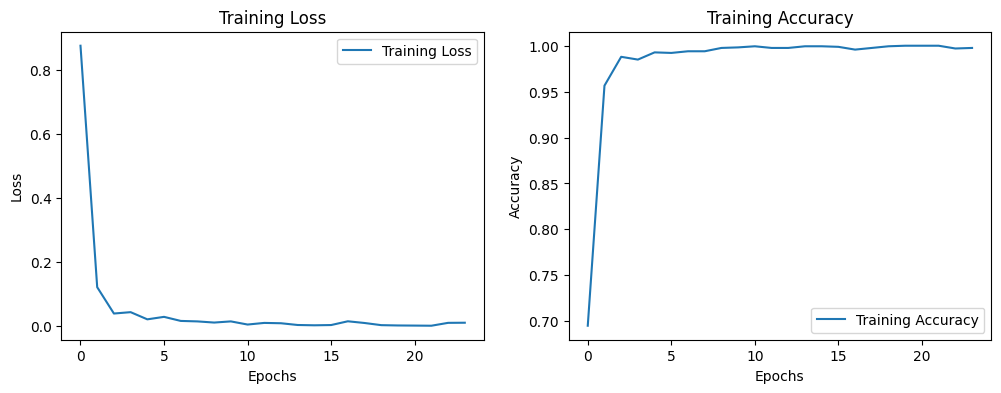

In [13]:
plt.figure(figsize=(12, 4))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

# Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

plt.show()

In [14]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

3/3 [==============================] - 1s 272ms/step - loss: 0.0150 - accuracy: 0.9861
Test Loss: 0.014989961870014668
Test Accuracy: 0.9861111044883728


3/3 [==============================] - 1s 230ms/step


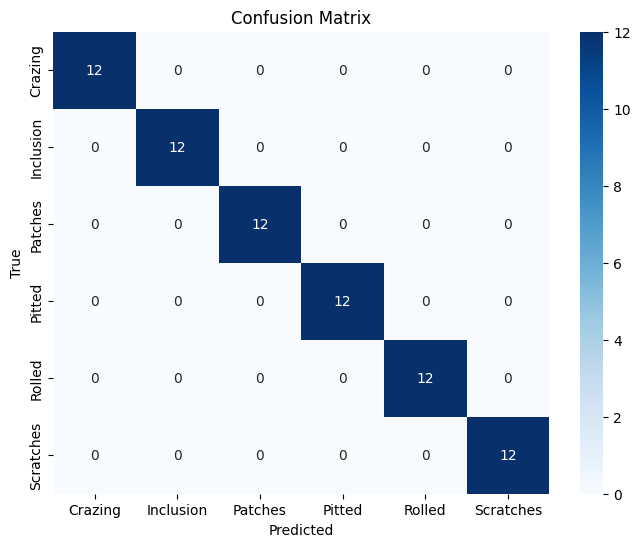

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true labels
true_labels = test_generator.classes

# Get the predicted labels
predicted_labels = model.predict(test_generator)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
